In [15]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader


In [16]:
dataset_filepath = '/content/dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']


In [17]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels


In [4]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)


In [5]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


In [6]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)


In [7]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [8]:
def fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )

        val_losses.append(val_loss)

        print(f'EPOCH {epoch+1}: \tTrain loss: {train_loss:.4f} \tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [9]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [10]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)


In [11]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)


In [12]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)


EPOCH 1: 	Train loss: 126.7144 	Val loss: 41.0000
EPOCH 2: 	Train loss: 29.9093 	Val loss: 7.3274
EPOCH 3: 	Train loss: 16.1273 	Val loss: 3.4272
EPOCH 4: 	Train loss: 13.1546 	Val loss: 3.0708
EPOCH 5: 	Train loss: 11.6122 	Val loss: 2.1856
EPOCH 6: 	Train loss: 10.6032 	Val loss: 1.8872
EPOCH 7: 	Train loss: 10.1788 	Val loss: 1.7648
EPOCH 8: 	Train loss: 9.6495 	Val loss: 1.8416
EPOCH 9: 	Train loss: 9.3395 	Val loss: 2.0046
EPOCH 10: 	Train loss: 9.1364 	Val loss: 1.6814
EPOCH 11: 	Train loss: 8.8933 	Val loss: 1.5721
EPOCH 12: 	Train loss: 8.8007 	Val loss: 1.5610
EPOCH 13: 	Train loss: 8.4925 	Val loss: 2.1109
EPOCH 14: 	Train loss: 8.4098 	Val loss: 1.8387
EPOCH 15: 	Train loss: 8.2465 	Val loss: 1.6703
EPOCH 16: 	Train loss: 7.8910 	Val loss: 1.9198
EPOCH 17: 	Train loss: 7.8164 	Val loss: 1.5562
EPOCH 18: 	Train loss: 7.7346 	Val loss: 1.9940
EPOCH 19: 	Train loss: 7.5003 	Val loss: 1.5797
EPOCH 20: 	Train loss: 7.4499 	Val loss: 1.5617
EPOCH 21: 	Train loss: 7.2653 	Val loss:

In [13]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset')
print('Val loss:', val_loss)
print('Test loss:', test_loss)


Evaluation on val / test dataset
Val loss: (1.519397990293652, 0.005391394504924832)
Test loss: (1.3313042788764393, 0.006639692914202718)


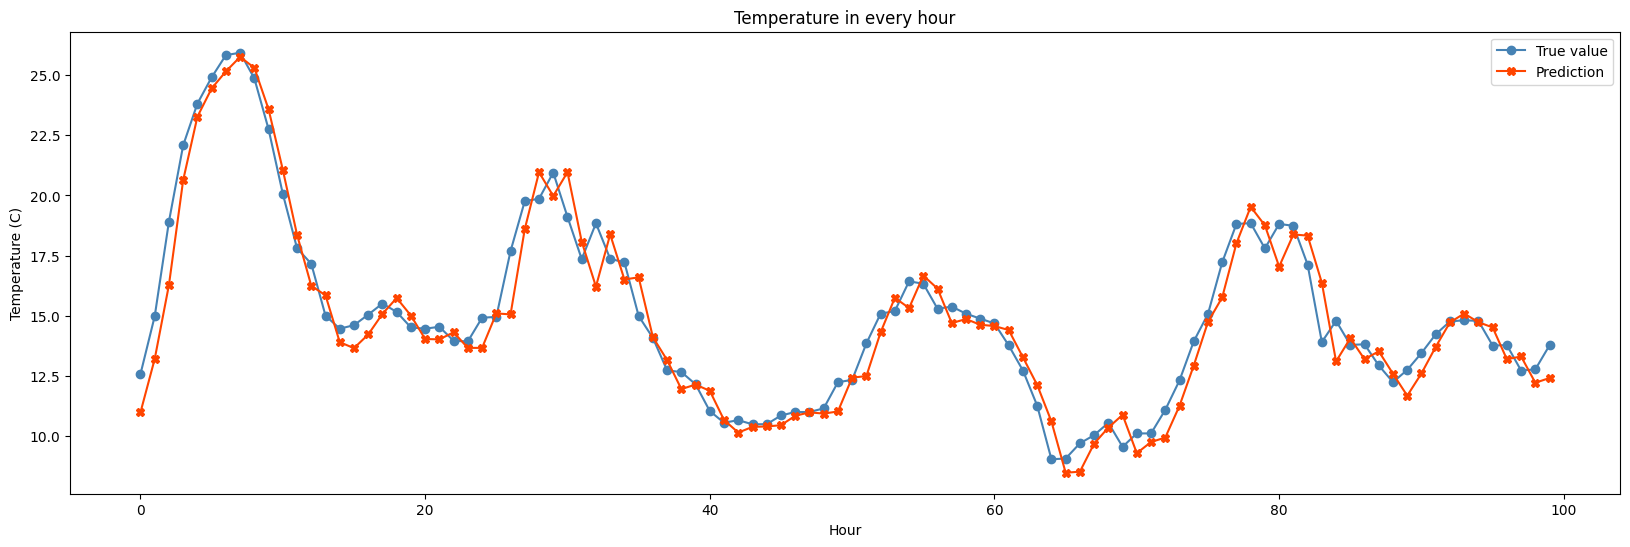

In [14]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)
